## Import Libraries

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import mne
from pandas import Series

## Starting The Process of Testing PanTompkins Algorithm

In [3]:
def max_div(arr):
    maximum = np.max(arr)
    arr = arr/maximum
    return arr

In [ ]:
plt.plot(max_div(ECG_raw[:2000]))

In [4]:
def BandPassECG(file,Fs):
    '''
    This function takes in a "path" and imports the ECG signal in .mat format
    '''
    # Import the signal
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    ECG    = raw_data[7]
    # Implementing the Butterworth BP filter
    W1     = 5*2/Fs                                    # --> 5 Hz cutt-off (high-pass) and Normalize by Sample Rate
    W2     = 15*2/Fs                                   # --> 15 Hz cutt-off (low-pass) and Normalize by Sample Rate
    b, a   = signal.butter(4, [W1,W2], 'bandpass')     # --> create b,a coefficients , since this is IIR we need both b and a coefficients
    ECG    = np.asarray(ECG)                           # --> let's convert the ECG to a numpy array, this makes it possible to perform vector operations 
    ECG    = np.squeeze(ECG)                           # --> squeeze
    ECG_BP = signal.filtfilt(b,a,ECG)    # --> filtering: note we use a filtfilt that compensates for the delay
    return ECG_BP,ECG

In [5]:
file='SN001.edf'
Fs = 256
ECG_BP,ECG_raw = BandPassECG(file,Fs)

Extracting EDF parameters from c:\Users\Mreza\Documents\Jupyter\Signal\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


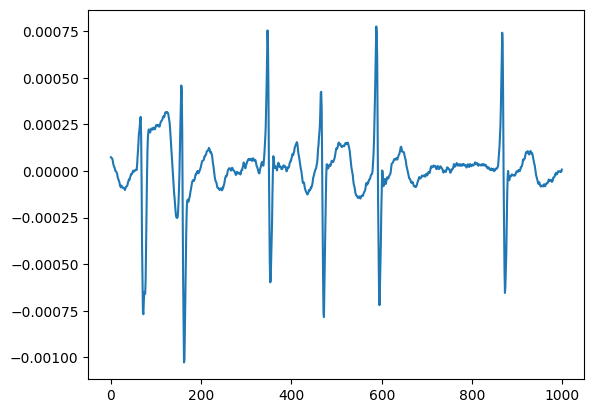

In [5]:
plt.plot(ECG_raw[:1000])
plt.savefig('raw.png',dpi=150)

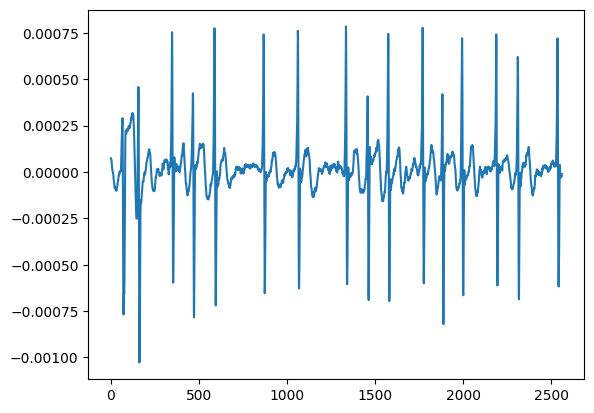

In [6]:
plt.plot(ECG_raw[:10*256])
plt.savefig('raw.png',dpi=150)

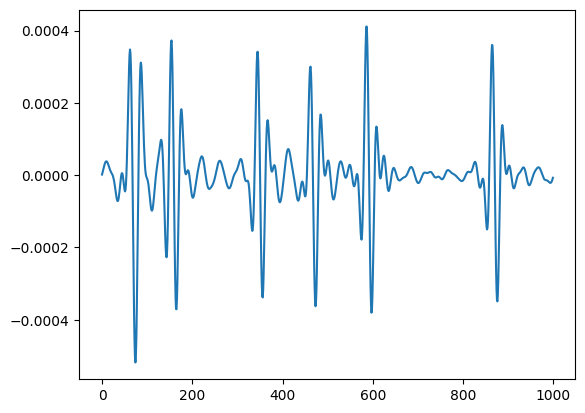

In [5]:
plt.plot(ECG_BP[:1000])
# plt.savefig('fil_raw.png', dpi=150)

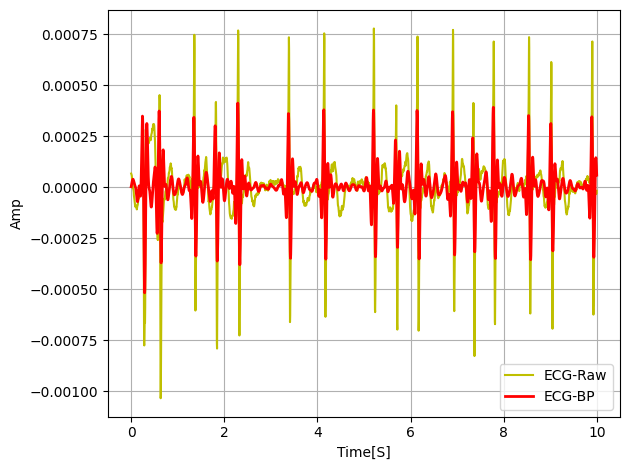

In [6]:
ts_raw = Series(np.squeeze(ECG_raw[:10*Fs] - np.mean(ECG_raw)), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)
ts_BP = Series(np.squeeze(ECG_BP[:10*Fs]), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)

# Styling the figures and colorcoding
fig = plt.figure(frameon="False"); ts_raw.plot(style='y',label='ECG-Raw') 
ts_BP.plot(style='r', label='ECG-BP',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]',); plt.legend()
plt.grid(True,'both'); plt.tight_layout(); 
plt.savefig('add_filraw.png',dpi=300)
plt.show()

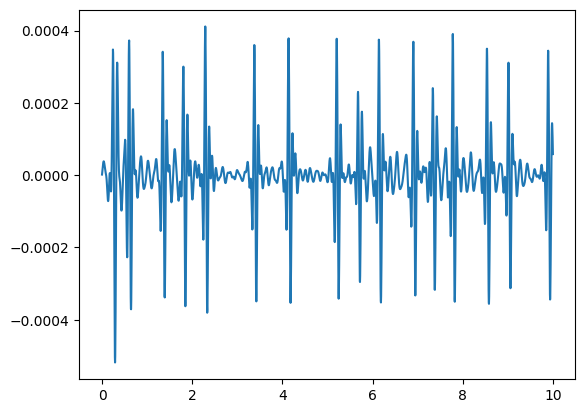

In [10]:
plt.plot(ts_BP)

In [7]:
def Differentiate(ECG):
    '''
    Compute single difference of the signal ECG
    '''
    ECG_df  = np.diff(ECG)
    ECG_sq  = np.power(ECG_df,2)
    return np.insert(ECG_sq,0, ECG_sq[0])

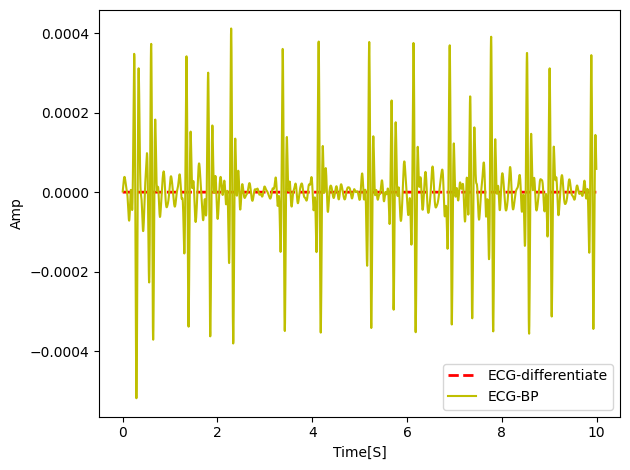

In [8]:
ECG_df = Differentiate(ECG_BP)
ts_df = Series(np.squeeze(ECG_df[:10*Fs]), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)
fig = plt.figure(frameon="False"); ts_df.plot(style='r--', label='ECG-differentiate',linewidth=2.0); 
ts_BP.plot(style='y',label='ECG-BP')
plt.ylabel('Amp'); plt.xlabel('Time[S]',); plt.legend()
plt.tight_layout(); plt.show()
fig.savefig('ECG_df.png', transparent=True)

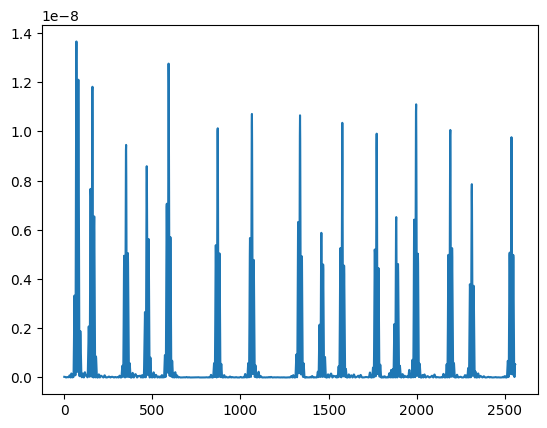

In [10]:
plt.plot(ECG_df[:10*Fs])
plt.savefig('diffed.png', dpi=150)

In [9]:

def MovingAverage(ECG,N=30):
    '''
    Compute moving average of signal ECG with a rectangular window of N
    '''
    window  = np.ones((1,N))/N
    ECG_ma  = np.convolve(np.squeeze(ECG),np.squeeze(window))
    return ECG_ma

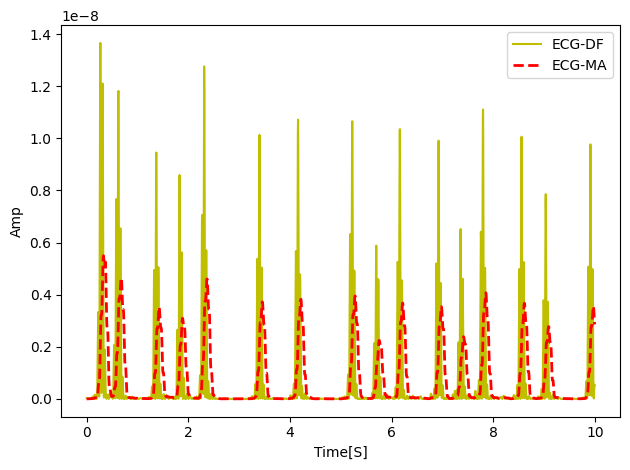

In [10]:
ECG_ma = MovingAverage(ECG_df)
ts_ma = Series(np.squeeze(ECG_ma[:10*Fs]), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)
fig = plt.figure(frameon="False"); ts_df.plot(style='y',label='ECG-DF') 
ts_ma.plot(style='r--', label='ECG-MA',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]',); plt.legend()
plt.tight_layout(); plt.show()
fig.savefig('ECG_ma.png', transparent=True)

In [11]:
def QRSpeaks(ECG,Fs):
    '''
    Finds peaks in a smoothed signal ECG and sampling freq Fs.
    '''
    peaks, _  = signal.find_peaks(ECG, height=np.mean(ECG), distance=round(Fs*0.200))
    return peaks

In [12]:
QRS = QRSpeaks(ECG_ma,Fs)
print(QRS)
print(QRS[QRS<=10*Fs])

[     84     174     365 ... 6565707 6565874 6566103]
[  84  174  365  483  606  885 1079 1352 1474 1592 1787 1899 2011 2205
 2327 2552]


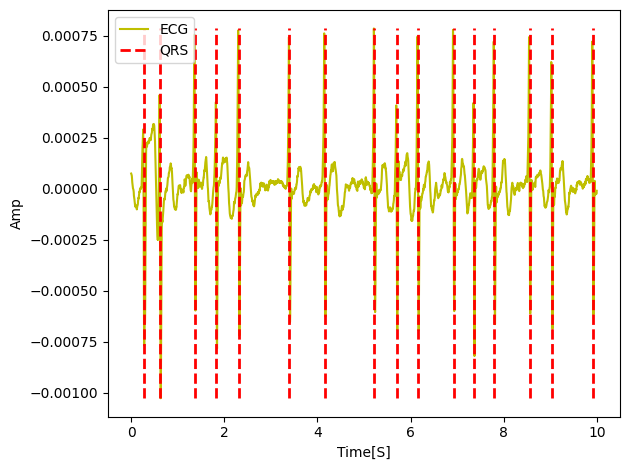

In [13]:
QRS = QRSpeaks(ECG_ma,Fs)
QRS = QRS[QRS<=10*Fs]
fig = plt.figure(frameon="False") 
plt.plot(np.arange(ECG_raw[:10*Fs].shape[0])/Fs,ECG_raw[:10*Fs],color='y',label='ECG')
plt.vlines(x=(QRS-15)/Fs,ymin=np.min(ECG_raw[:10*Fs]),ymax=np.max(ECG_raw[:10*Fs]),linestyles='dashed',color='r', label='QRS',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]'); plt.legend()
plt.tight_layout(); plt.show()
fig.savefig('QRS_pks.png', transparent=True)

Now, R Peaks on ECG signal has been marked.

Then, Trying to find any kind of abnormalities using mean of values as a simple way. 

In [14]:
##My part
#HRV
QRS = QRSpeaks(ECG_ma,Fs)
hrv = np.diff(QRS)

In [29]:
hrv.shape

(37886,)

In [20]:
print(np.round(hrv,decimals=4)[:10])

[ 90 191 118 123 279 194 273 122 118 195]


In [25]:
# with open('hrv_pts.txt','w') as file:
#     file.write(str(hrv[::]))
np.savetxt('hrv_pts.csv',hrv, fmt='%d') #d int f float

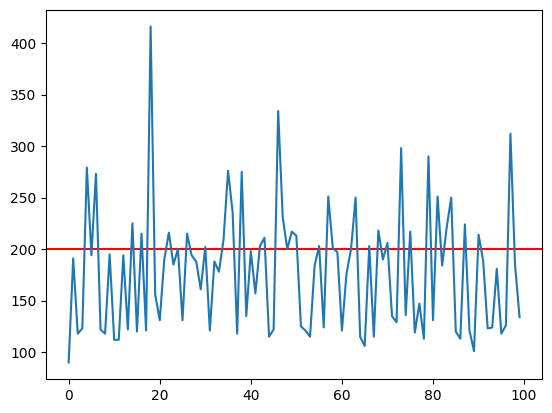

In [44]:
fig = plt.figure(frameon="False") 
plt.axhline(y=200, xmin=0.0, xmax=1.0, color='r')
plt.plot(hrv[:100])


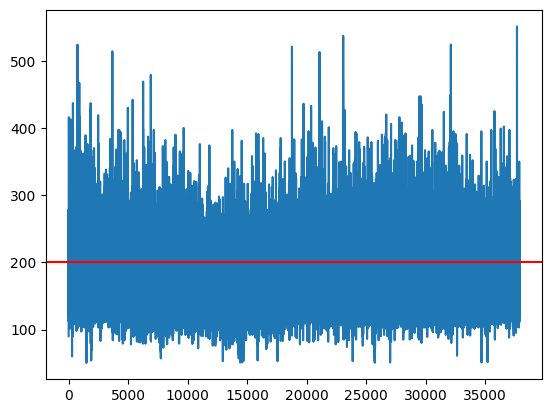

In [17]:
fig = plt.figure(frameon="False") 
plt.plot(hrv)
plt.axhline(y=200, xmin=0.0, xmax=1.0, color='r')
plt.savefig('hrv.png', dpi=150)

In [24]:
mean_h = np.mean(hrv)
mean_h

173.3099033943937

In [26]:
hrv[:15]

array([ 90, 191, 118, 123, 279, 194, 273, 122, 118, 195, 112, 112, 194,
       122, 225], dtype=int64)

In [31]:
temp = 0
for i in range(hrv.shape[0]):
    temp += (hrv[i] - mean_h)
length_d = hrv.shape[0]
cost = temp / length_d
cost

7.176620416381167e-13

In [ ]:
if np.max(hrv) > np.mean(hrv)*3:
    array.pop()

In [20]:
cost.shape

(37886,)

In [33]:
# hb = HeartBeat
hb = (1/(hrv/256))*60
# hb = 300/rr_interval
hb

array([170.66666667,  80.41884817, 130.16949153, ...,  83.02702703,
        91.9760479 ,  67.07423581])

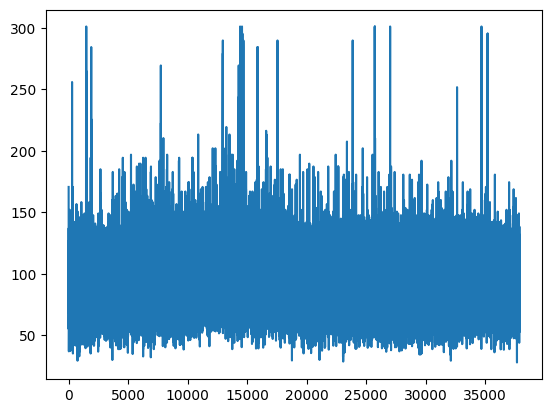

In [35]:
plt.plot(hb)
plt.savefig('hb.png',dpi=150)

In [50]:
import ast

with open(f"Merged_annotation_SN001.txt",'r') as file:
    text = file.read().split('\n')

res = []
for item in text:
    res.append(ast.literal_eval(item))
res[:5]

[[33, 210, 'Sleep stage W'],
 [210, 450, 'Sleep stage N1'],
 [510, 690, 'Sleep stage N2'],
 [690, 750, 'Sleep stage N1'],
 [780, 960, 'Sleep stage N1']]

In [53]:
filtered_annots= np.empty(len(res))
filtered_annots.shape

(58,)

In [83]:
QRS = QRS.astype('float32')
QRS/=256
QRS

array([3.2812500e-01, 6.7968750e-01, 1.4257812e+00, ..., 2.5647293e+04,
       2.5647945e+04, 2.5648840e+04], dtype=float32)

In [ ]:
# for rr in QRS:
i=0
j=0
filtered_annots= np.empty(len(res))
for item in res:
    tmp = item[2]
    while QRS[i]>=item[0] and QRS[i] <item[1]:
        np.append(filtered_annots[j][i], QRS[i])
        i+=1
    np.append(filtered_annots[j], tmp)
    j+=1

In [109]:
QRS[::-1]

array([6566103, 6565874, 6565707, ...,     365,     174,      84],
      dtype=int64)

In [105]:
dtqrs=[i/256 for i in QRS]
dtqrs[:10]

[0.328125,
 0.6796875,
 1.42578125,
 1.88671875,
 2.3671875,
 3.45703125,
 4.21484375,
 5.28125,
 5.7578125,
 6.21875]

In [106]:
for item in res:
    item[0] = item[0]*256
    item[1] = item[1]*256

In [107]:
for item in res[:5]:
    print(item)

[8448, 53760, 'Sleep stage W']
[53760, 115200, 'Sleep stage N1']
[130560, 176640, 'Sleep stage N2']
[176640, 192000, 'Sleep stage N1']
[199680, 245760, 'Sleep stage N1']


In [123]:
j=0
filtered_annots= []
for item in res[:5]:
    tmp = item[2]
    for num in QRS:
        if num>=item[0] and num<item[1]:
            filtered_annots.append(num)
            
    filtered_annots.append(tmp)
    with open(f'ann{j}.txt','w') as file:
        file.write(str(filtered_annots))
    j+=1
    filtered_annots= []


In [124]:
filtered_annots

[]